
In <a href='https://medium.com/intellectual-explorers-club/memetic-tribes-and-culture-war-2-0-14705c43f6bb' target='_blank'>Memetic Tribes and Culture War 2.0</a>, Peter Limberg and Conor Barnes reference a Google Spreadsheet where they are compiling their data.

<figure name="7247" id="7247" class="graf graf--figure graf--layoutOutsetCenter graf-after--p" data-scroll="native">
    <img src="https://cdn-images-1.medium.com/max/1000/1*k3zWQFbKT51T96AAMdfKdA.png">
    <figcaption class="imageCaption">
        Click <a href="https://docs.google.com/spreadsheets/d/11Ov1Y1xM-LCeYSSBYZ7yPXJah2ldgFX4oIlDtdd7-Qw/edit?usp=sharing" target="_blank">here</a> to view the full chart.
    </figcaption>
</figure>

One of the columns contains lists of records from another column. I am going to convert this into a directed graph using <code>pandas</code> and <code>networkx</code>.

The easiest way to get data out of html tables on the web is to use <code>pandas</code> <code>read_html</code> function, but you have to pick through the tables in the list to see which one contains the data you want.

In [16]:

import pandas as pd

tables_url = r'https://docs.google.com/spreadsheets/d/11Ov1Y1xM-LCeYSSBYZ7yPXJah2ldgFX4oIlDtdd7-Qw'
tribes_df_list = pd.read_html(tables_url)
print(len(tribes_df_list))

2



I had to perform a lot of <a href='https://secure.i.telegraph.co.uk/multimedia/archive/02152/panda-upside-down_2152868i.jpg' target='_blank'>panda gymnastics</a> in order to clean off the husk of the Google table and get the data into a compact space.

In [15]:

tribes_df = tribes_df_list[0].dropna(axis=0, how='all').dropna(axis=1, how='all').iloc[:, 1:]
tribes_df.columns = tribes_df.iloc[0]
tribes_df = tribes_df.iloc[1:].T
tribes_df.columns = tribes_df.iloc[0]
tribes_df = tribes_df.iloc[1:].T
tribes_df.sample(3).T.sample(6).T

,EXISTENTIAL THREATS,FOREBEARERS,SACRED VALUES,MENTAL MODELS,CHIEFTAINS,COMBATANTS
MEMETIC TRIBE,,,,,,
Occupy,Police crackdown,"Adbusters, Arab Spring",Economic Justice,"The 99%, Culture Jamming, Crony Capitalism","Kalle Lasn, Naomi Klein, David Graeber","Establishment Left, Establishment Right"
Black Lives Matter,Systemic racism,"Audre Lorde, Franz Fanon, Malcolm X",Restorative Justice,"Black Bodies, Reparations, Cultural Appropriat...","Alicia Garza, DeRay Mckesson, Ta Nehisi Coates","Alt-Lite, Alt-Right, Trumpists, Establishment ..."
Tea Party,Debt crisis,Ron Paul,"Fiscal Responsibility, Freedom (from government)","Lamestream Media, Don't Tread on Me, Moneybombing","Sarah Palin, Glenn Beck, Amy Kremer","Establishment Left, Establishment Right"



It's an easy matter to add the tribes into a directional graph.

In [27]:

import networkx as nx

tribes_digraph = nx.DiGraph()
tribes_digraph.add_nodes_from(tribes_df.T.to_dict())


Next is figuring out, from the combatant lists, where the edges are.

In [29]:

from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

tribe_list = tribes_df.index.tolist()
for row_index, row_series in pd.DataFrame(tribes_df['COMBATANTS']).iterrows():
    combatant_list = row_series['COMBATANTS'].split(', ')
    for combatant in combatant_list:
        if combatant != 'None':
            this_tribe = sorted(tribe_list,
                                key=lambda tribe: similar(combatant, tribe.split(' (')[0]))[-1]
            tribes_digraph.add_edge(row_index, this_tribe)


I have to use Gephi to get every node away from the other edges because networkx doesn't do that well enough.

In [50]:

# Export the graph into Gephi
SAVES_FOLDER = '../saves/'
file_path = SAVES_FOLDER+'/gexf/tribes_digraph.gexf'
nx.write_gexf(tribes_digraph, file_path)


I have decided to color the mutual combatants edge red. For this I need a list of edges that have arrows pointing both ways.

In [51]:

full_edge_list = list(tribes_digraph.edges())
double_edge_list = []
while len(full_edge_list) > 0:
    edge_tuple = full_edge_list.pop()
    doubled_tuple = (edge_tuple[1], edge_tuple[0])
    if doubled_tuple in full_edge_list:
        double_edge_list.append(edge_tuple)
        double_edge_list.append(doubled_tuple)

In [52]:

single_edge_list = []
full_edge_list = list(tribes_digraph.edges())
for edge_tuple in full_edge_list:
    if edge_tuple not in double_edge_list:
        single_edge_list.append(edge_tuple)

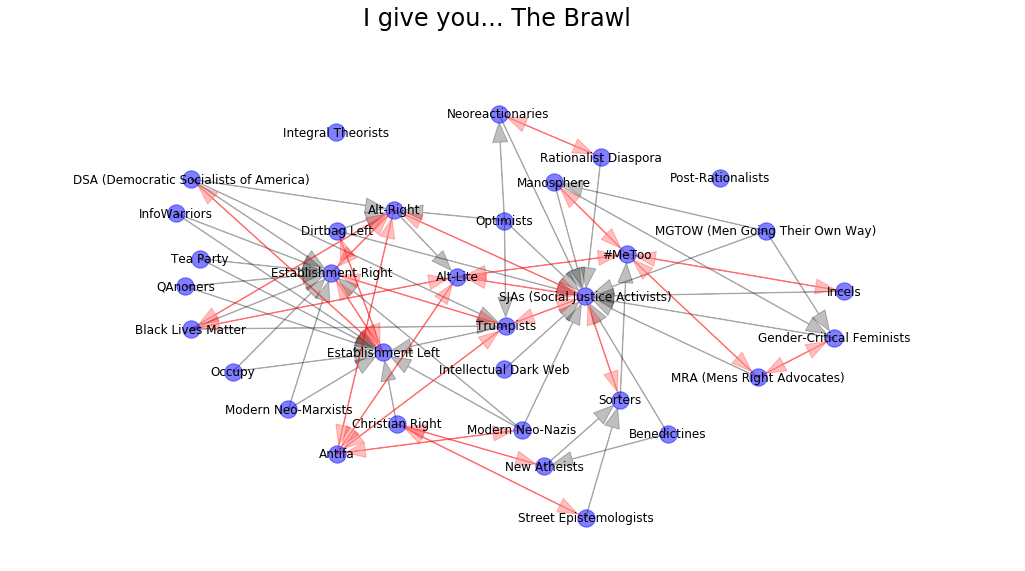

In [65]:

import xmltodict
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline

# Import from Gephi
with open(file_path, 'r') as fid:
    tribal_xml = fid.read()
tribal_tree = xmltodict.parse(tribal_xml)

# Get the position dictionary for the GEXF saved from Gephi
node_dict_list = tribal_tree['gexf']['graph']['nodes']['node']
tribal_layout_dict = {node_dict['@id']: np.array([float(node_dict['viz:position']['@x']),
                                                  float(node_dict['viz:position']['@y'])]) for node_dict in node_dict_list}

# Draw the graph using the gephi layout
tribal_fig = plt.figure(figsize=(18, 9))
ax = tribal_fig.add_subplot(111)
plt.axis('off')
plt.xticks([], [])
plt.yticks([], [])
tribal_fig.suptitle('I give you... The Brawl', fontsize=24)

# Make fat arrows
arrowstyle = mpatches.ArrowStyle.Simple(head_length=2., head_width=1.5, tail_width=0.05)

# Make the nodes blue so you can make the double edges red
node_collection = nx.draw_networkx_nodes(G=tribes_digraph, pos=tribal_layout_dict, alpha=0.5, node_color='b')

# Get the double-edged edge list in red
edge_collection = nx.draw_networkx_edges(G=tribes_digraph, pos=tribal_layout_dict, alpha=0.25,
                                         arrowstyle=arrowstyle, edgelist=single_edge_list)
edge_collection = nx.draw_networkx_edges(G=tribes_digraph, pos=tribal_layout_dict, alpha=0.25,
                                         arrowstyle=arrowstyle, edgelist=double_edge_list, edge_color='r')

labels_collection = nx.draw_networkx_labels(G=tribes_digraph, pos=tribal_layout_dict, font_size=12)
axes_subplot = tribal_fig.get_axes()[0]
xlim_tuple = axes_subplot.set_xlim(left=-1500, right=1500)

In [67]:
%%javascript
var kernel = IPython.notebook.kernel;
var body = document.body,  
    attribs = body.attributes;
var command = "notebook_path = " + "'"+attribs['data-notebook-path'].value+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [70]:
# %load ../../load_magic/nbviewer.py

from IPython.display import HTML

notebook_viewer_url = 'https://nbviewer.jupyter.org/github/dbabbitt/notebooks/blob/master/'
notebook_viewer_url += '/'.join(notebook_path.split('/')[1:])
HTML('Click <a href="' + notebook_viewer_url + '" target="_blank">here</a> to view notebook in nbviewer.')